In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import math

In [2]:
data1 = loadmat(r"./Anomalies_detection_data1.mat")

In [3]:
dataset1 = data1['X']

In [4]:
#Visualize the data
def Visualize_data(X,y,xlabel,ylabel):
    plt.scatter(X,y,c="red",marker="x")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

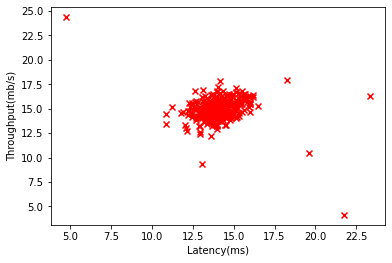

In [5]:
#Visualize the data
Visualize_data(dataset1[:,0],dataset1[:,1],"Latency(ms)","Throughput(mb/s)")

In [6]:
#calculate mean and variance
def Calc_mean_variance(dataset):
    mu = np.mean(dataset,axis=0)
    var = np.var(dataset,axis=0)
    
    return mu,var

In [7]:
mean,var = Calc_mean_variance(dataset1)

In [8]:
def Calc_Gaussian_Distribution(dataset,mean,var):
    if var.ndim == 1:
        var = np.diag(var)
    n = mean.size
    norm_dataset = dataset - mean
    non_exp_term = ((2*math.pi)**(-n/2)) * (np.linalg.det(var) ** (-0.5))

    exp_term = np.exp(-0.5 * np.sum(np.dot(norm_dataset, np.linalg.pinv(var)) * norm_dataset, axis=1))

    p = non_exp_term*exp_term
    
    return p

In [9]:
gaussian_prob = Calc_Gaussian_Distribution(dataset1,mean,var)
print("The shape of the gaussian probability is:",gaussian_prob.shape)

The shape of the gaussian probability is: (307,)


In [10]:
def Contour_Plot(X,y,mean,var):
    
    X1,X2 = np.meshgrid(np.arange(0,35.5,0.5),np.arange(0,35.5,0.5))
    
    P_X = Calc_Gaussian_Distribution(np.stack([X1.ravel(), X2.ravel()], axis=1), mean, var)

    P_X = P_X.reshape(X1.shape)

    plt.plot(X, y, 'bx', mec='b', mew=2, ms=8)

    if np.all(abs(P_X) != np.inf):
        plt.contour(X1, X2, P_X, levels=10**(np.arange(-20., 1, 3)), zorder=100)

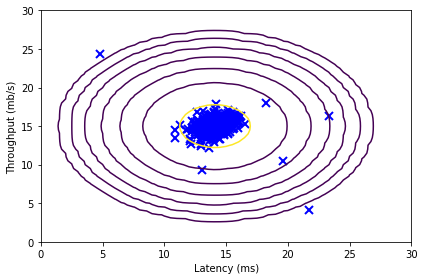

In [11]:
Contour_Plot(dataset1[:,0],dataset1[:,1],mean,var)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0,30)
plt.ylim(0,30)
plt.tight_layout()

In [12]:
#Select threshold from the validation set

xval,yval = data1['Xval'],data1['yval']

In [13]:
def set_threshold(pval,yval,epsilon_max_range,no_values):
    best_F1 = -9999
    best_epsilon = -9999
    F1 = 0
    
    for epsilon in np.linspace(1.01*min(pval),epsilon_max_range*max(pval),no_values):
        pred = pval < epsilon
        
        tp = np.sum((pred==1) & (yval==1))
        fp = np.sum((pred==1) & (yval==0))
        fn = np.sum((pred==0) & (yval==1))
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        
        F1 = 2*precision*recall/(precision + recall)
        if F1>best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    
    return best_F1,best_epsilon

In [14]:
pval = Calc_Gaussian_Distribution(xval,mean,var)

In [15]:
epislon_maxRange = 0.006
no_values = 30000
F1,epsilon = set_threshold(pval,yval,epislon_maxRange,no_values)

In [16]:
print("The best F1 score is:",F1)
print("The best epsilon value:",epsilon)

The best F1 score is: 0.027591492623107877
The best epsilon value: 0.0004989010690517408


In [17]:
#find the outliers 
outliers = gaussian_prob < epsilon

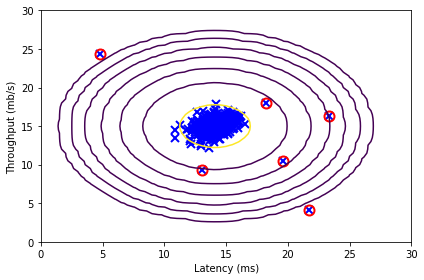

In [18]:
#  highlight the outliers
Contour_Plot(dataset1[:,0],dataset1[:,1],mean,var)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0,30)
plt.ylim(0,30)
plt.tight_layout()

#  Draw a red circle around those outliers
plt.plot(dataset1[outliers, 0], dataset1[outliers, 1], 'ro', ms=10, mfc='None', mew=2)

### Higher Dimensional Dataset

In [19]:
data2 = loadmat(r"./Anomalies_detection_data2.mat")

In [20]:
X2,Xval2,yval2 = data2['X'],data2['Xval'],data2['yval'][:,0]

In [21]:
#calculate mean and variance
mean2, var2 = Calc_mean_variance(X2)

#Calculate Gaussian Probability
gaussian_prob2 = Calc_Gaussian_Distribution(X2,mean2,var2)

In [22]:
pval2 = Calc_Gaussian_Distribution(Xval2,mean2,var2)

In [23]:
no_values2 = 1000
epsilon_max_range2 = 1
F1_hd,epsilon_hd = set_threshold(pval2,yval2,epsilon_max_range2,no_values2)

In [24]:
print("The best F1 score is:",F1_hd)
print("The best epsilon value:",epsilon_hd)

The best F1 score is: 0.6153846153846154
The best epsilon value: 1.3786074987947638e-18


In [25]:
#Lets check what is the number of outliers found
outliers2 = gaussian_prob2 < epsilon_hd

print("The number of outliers found is:",np.sum(outliers2))

The number of outliers found is: 117
